In [1]:
from keras.applications import VGG19
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
model = VGG19(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [3]:
def process_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)  # to avoid 0 division
    x *= 0.1               # ensure that std is 0.1
    
    x += 0.5
    x = np.clip(x,0,1)     # clips to [0,1]
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')    # convert to RGB
    
    return x

In [4]:
def generate_pattern(layer_name, filter_index, size=150):
    
    layer_output = model.get_layer(layer_name).output
    
    # define the loss, as previous
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # compute the gradients of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]
    
    # normalization trick
    grads /= K.sqrt(K.mean(K.square(grads))) + 1.e-5
    
    # iterator to return the loss and grads given the input picture
    iterate = K.function([model.input], [loss,grads])
    
    # random gray image + noise
    input_img_data = np.random.random((1,size,size,3)) *20 + 128.
    
    # runs gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return process_image(img)

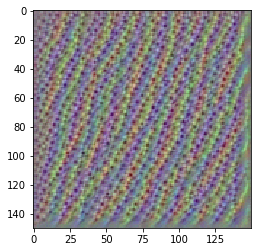

In [5]:
plt.imshow(generate_pattern('block3_conv1',0))

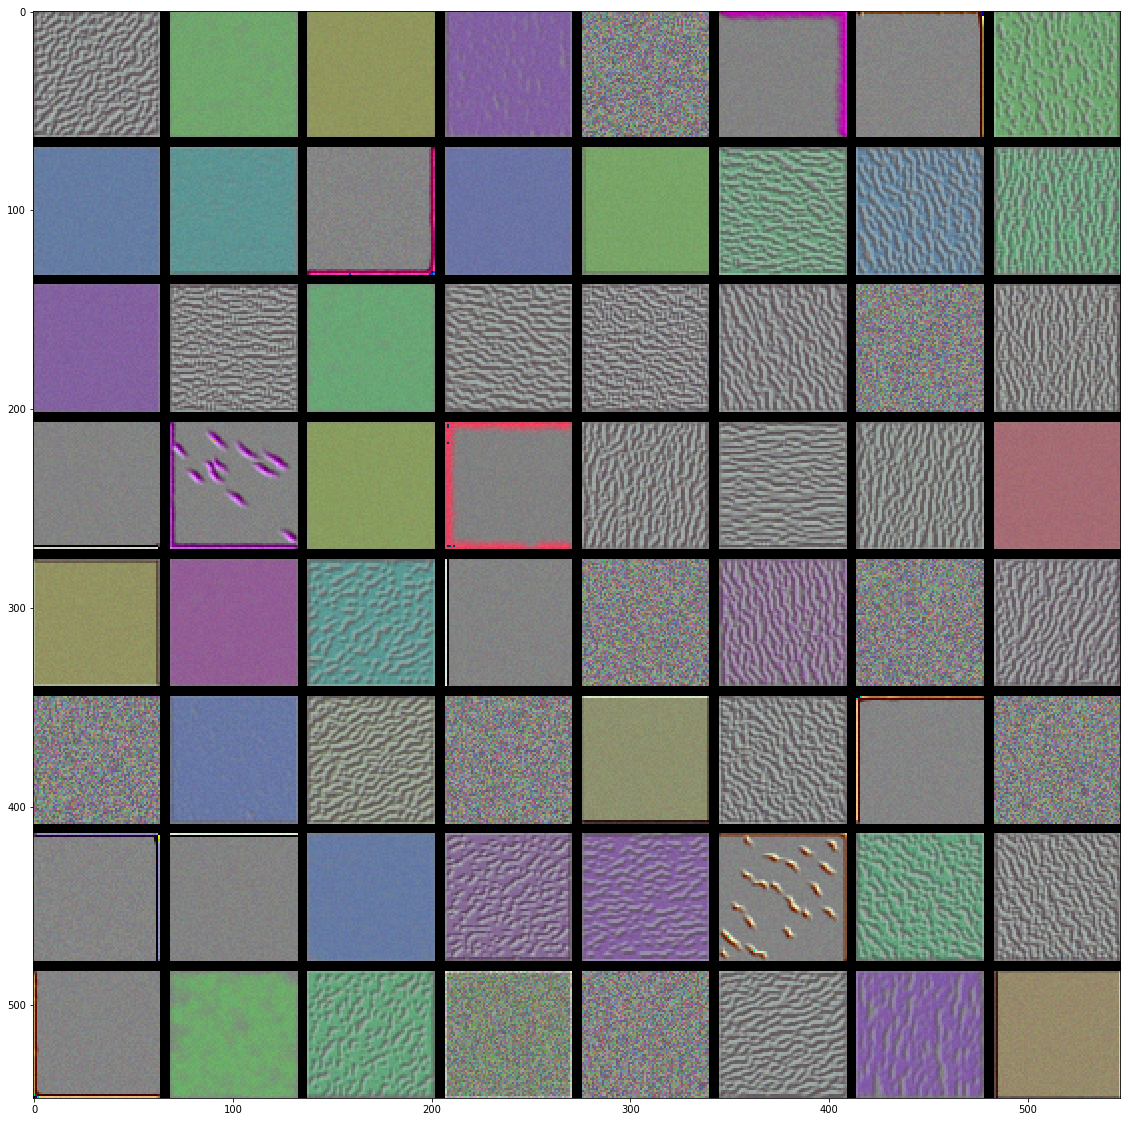

In [6]:
layer_name = 'block1_conv1'

size = 64
margin = 5

results = np.zeros((8*size + 7*margin, 8*size + 7*margin, 3))

# generate the pattern for filter i + (j*8) in layer_name
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i+(j*8), size=size)
        
        # Put the results in a square (i,j)
        horizontal_start = i*size + i*margin
        horizontal_end = horizontal_start + size
        vertical_start = j*size + j*margin
        vertical_end = vertical_start + size
        
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img
        
plt.figure(figsize=(20,20))
plt.imshow(results)